In [1]:
import featuretools as ft

In [2]:
data = ft.demo.load_mock_customer()

In [3]:
transactions_df = data['transactions'].merge(data['sessions']).merge(data['customers'])

In [4]:
transactions_df.sample(5)

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device,session_start,zip_code,join_date,date_of_birth
264,380,21,2014-01-01 05:14:10,5,57.09,4,desktop,2014-01-01 05:02:15,60091,2011-04-08 20:08:14,2006-08-15
19,244,10,2014-01-01 02:34:55,2,116.95,2,tablet,2014-01-01 02:31:40,13244,2012-04-15 23:31:04,1986-08-18
314,299,6,2014-01-01 01:32:05,4,64.99,1,tablet,2014-01-01 01:23:25,60091,2011-04-17 10:48:33,1994-07-18
290,78,4,2014-01-01 00:54:10,1,37.50,1,mobile,2014-01-01 00:44:25,60091,2011-04-17 10:48:33,1994-07-18
379,457,27,2014-01-01 06:37:35,1,19.16,1,mobile,2014-01-01 06:34:20,60091,2011-04-17 10:48:33,1994-07-18


In [5]:
products_df = data['products']
products_df.sample(5)

,product_id,brand
3,4,B
2,3,B
4,5,A
0,1,B
1,2,B


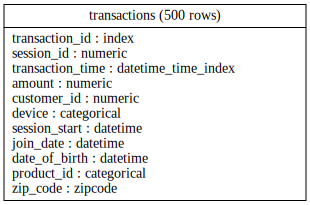

In [11]:
es = ft.EntitySet(id='customer_data')
es = es.entity_from_dataframe(
    entity_id='transactions',
    dataframe=transactions_df,
    index='transaction_id',
    time_index='transaction_time',
    variable_types={
        'product_id': ft.variable_types.Categorical,
        'zip_code': ft.variable_types.ZIPCode
    }
)
es.plot()

In [8]:
es['transactions'].variables

[<Variable: transaction_id (dtype = index)>,
 <Variable: session_id (dtype = numeric)>,
 <Variable: transaction_time (dtype: datetime_time_index, format: None)>,
 <Variable: amount (dtype = numeric)>,
 <Variable: customer_id (dtype = numeric)>,
 <Variable: device (dtype = categorical)>,
 <Variable: session_start (dtype: datetime, format: None)>,
 <Variable: join_date (dtype: datetime, format: None)>,
 <Variable: date_of_birth (dtype: datetime, format: None)>,
 <Variable: product_id (dtype = categorical)>,
 <Variable: zip_code (dtype = zipcode)>]

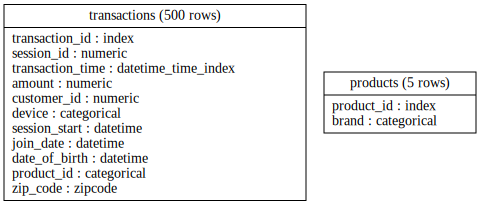

In [14]:
es = es.entity_from_dataframe(
    entity_id='products',
    dataframe=products_df,
    index='product_id'
)
es.plot()

In [15]:
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 11]
    products [Rows: 5, Columns: 2]
  Relationships:
    No relationships

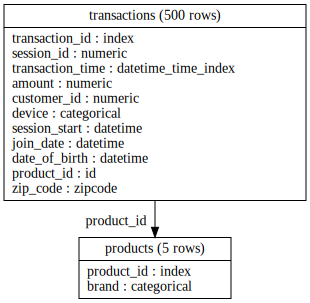

In [16]:
es = es.add_relationship(
    ft.Relationship(
        es['products']['product_id'],
        es['transactions']['product_id']
    )
)
es.plot()

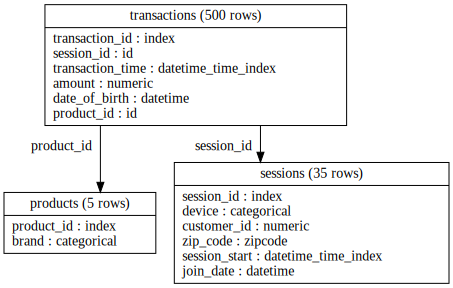

In [17]:
# create new entity and relationship for sessions (normalize the transaction entity)
es = es.normalize_entity(
    base_entity_id='transactions',
    new_entity_id='sessions',
    index='session_id',
    make_time_index='session_start',
    additional_variables=['device', 'customer_id', 'zip_code', 'session_start', 'join_date']
)
es.plot()

In [20]:
es['sessions'].df.sample(5)

,session_id,device,customer_id,zip_code,session_start,join_date
14,14,tablet,1,60091,2014-01-01 03:28:00,2011-04-17 10:48:33
12,12,desktop,4,60091,2014-01-01 03:04:10,2011-04-08 20:08:14
19,19,desktop,3,13244,2014-01-01 04:27:35,2011-08-13 15:42:34
32,32,mobile,5,60091,2014-01-01 08:02:05,2010-07-17 05:27:50
17,17,tablet,2,13244,2014-01-01 04:00:30,2012-04-15 23:31:04


In [22]:
es['sessions'].variables

[<Variable: session_id (dtype = index)>,
 <Variable: device (dtype = categorical)>,
 <Variable: customer_id (dtype = numeric)>,
 <Variable: zip_code (dtype = zipcode)>,
 <Variable: session_start (dtype: datetime_time_index, format: None)>,
 <Variable: join_date (dtype: datetime, format: None)>]

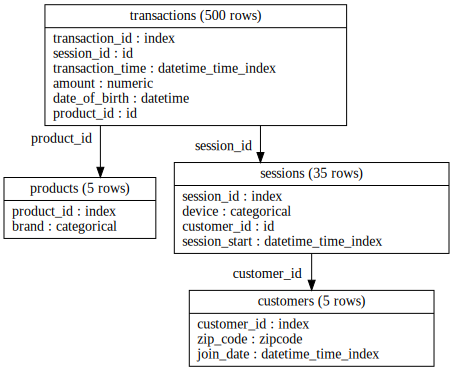

In [24]:
es = es.normalize_entity(
    base_entity_id="sessions",
    new_entity_id='customers',
    index='customer_id',
    make_time_index='join_date',
    additional_variables=['zip_code', 'join_date']
)
es.plot()

In [25]:
# build a feature matrix for each product in our dataset
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity='products')
feature_matrix.sample(5)

,brand,SUM(transactions.amount),STD(transactions.amount),MAX(transactions.amount),SKEW(transactions.amount),MIN(transactions.amount),MEAN(transactions.amount),COUNT(transactions),NUM_UNIQUE(transactions.session_id),MODE(transactions.session_id),...,MODE(transactions.WEEKDAY(transaction_time)),MODE(transactions.YEAR(transaction_time)),MODE(transactions.DAY(date_of_birth)),MODE(transactions.DAY(transaction_time)),MODE(transactions.YEAR(date_of_birth)),MODE(transactions.MONTH(transaction_time)),MODE(transactions.sessions.device),MODE(transactions.MONTH(date_of_birth)),MODE(transactions.WEEKDAY(date_of_birth)),MODE(transactions.sessions.customer_id)
product_id,,,,,,,,,,,,,,,,,,,,,
3,B,7008.12,38.871405,148.31,0.223938,5.89,73.001250,96,35,1,...,2,2014,18,1,2006,1,desktop,8,0,4
4,B,8088.97,42.492501,146.46,-0.132077,5.81,76.311038,106,34,29,...,2,2014,18,1,1994,1,desktop,7,0,1
2,B,7021.43,46.336308,149.95,0.151934,5.73,76.319891,92,34,28,...,2,2014,18,1,2006,1,desktop,8,0,4
1,B,7489.79,42.479989,149.56,0.125525,6.84,73.429314,102,34,3,...,2,2014,18,1,1994,1,desktop,7,0,1
5,A,7931.55,42.131902,149.02,0.098248,5.91,76.264904,104,34,4,...,2,2014,18,1,1994,1,mobile,7,0,1
